# **Forecasting Base Station using Chronos T5 Models**

In [2]:
import pandas as pd
import torch
import numpy as np
from chronos import ChronosPipeline  
from sklearn.metrics import mean_squared_error
import logging
import matplotlib.pyplot as plt
import time
import gc

/home/infres/vonguyen/rai-6green-miniproj/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [4]:
# Utility function   
def load_series_from_file(file_path):
    """Load and prepare data from CSV file"""
    df = pd.read_csv(file_path)
    grouped = df.groupby('item_id')
    series_list = []
    for _, group in grouped:
        group = group.sort_values('timestamp')
        target = torch.tensor(group['target'].values, dtype=torch.float32)
        series_list.append(target)
    return series_list

def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [5]:
logger.info("Loading data...")
train_series = load_series_from_file("/home/infres/vonguyen/rai-6green-miniproj/dataset/train.csv")
test_series = load_series_from_file("/home/infres/vonguyen/rai-6green-miniproj/dataset/test.csv")

INFO:__main__:Loading data...


## **Evaluation**

In [7]:

# Model list to validate
model_names = [
    "amazon/chronos-t5-tiny",
    "amazon/chronos-t5-small",
    "amazon/chronos-t5-base",
    "amazon/chronos-t5-mini"
]

results = []
prediction_length = 8

# Vòng lặp qua từng mô hình
for model_name in model_names:
    logger.info(f"--- Start validating model: {model_name} ---")

    try:
        pipeline = ChronosPipeline.from_pretrained(
            model_name,
            device_map="cpu",
            torch_dtype=torch.bfloat16
        )

        all_predictions = []
        all_actuals = []
        
        start = time.time()

        for i, (context, actuals_tensor) in enumerate(zip(train_series, test_series)):
            actuals = actuals_tensor.numpy()

            # Lấy dự báo
            forecast = pipeline.predict(
                context=context,
                prediction_length=prediction_length,
                num_samples=20,
            )
            median_prediction = np.quantile(forecast[0].numpy(), 0.5, axis=0)

            all_predictions.extend(median_prediction.flatten())
            all_actuals.extend(actuals)
            
        elapse = time.time() - start
        logger.info(f"Forecast time of {model_name}: {elapse:.2f} seconds")
        
        rmse = calculate_rmse(np.array(all_actuals), np.array(all_predictions))
        results.append({'Model': model_name, 'RMSE': rmse, 'Time': elapse})
        logger.info(f"Finished {model_name}. RMSE: {rmse:.4f}")

        del pipeline
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    except Exception as e:
        logger.error(f"Error at {model_name}: {e}")
        results.append({'Model': model_name, 'RMSE': 'N/A', 'Time': 'N/A'})
        continue

logger.info("--- Finish Validation ---")

INFO:__main__:--- Start validating model: amazon/chronos-t5-tiny ---
INFO:__main__:Forecast time of amazon/chronos-t5-tiny: 255.23 seconds
INFO:__main__:Finished amazon/chronos-t5-tiny. RMSE: 9.1564
INFO:__main__:Forecast time of amazon/chronos-t5-tiny: 255.23 seconds
INFO:__main__:Finished amazon/chronos-t5-tiny. RMSE: 9.1564
INFO:__main__:--- Start validating model: amazon/chronos-t5-small ---
INFO:__main__:--- Start validating model: amazon/chronos-t5-small ---
INFO:__main__:Forecast time of amazon/chronos-t5-small: 631.38 seconds
INFO:__main__:Finished amazon/chronos-t5-small. RMSE: 9.0531
INFO:__main__:Forecast time of amazon/chronos-t5-small: 631.38 seconds
INFO:__main__:Finished amazon/chronos-t5-small. RMSE: 9.0531
INFO:__main__:--- Start validating model: amazon/chronos-t5-base ---
INFO:__main__:--- Start validating model: amazon/chronos-t5-base ---
INFO:__main__:Forecast time of amazon/chronos-t5-base: 1720.65 seconds
INFO:__main__:Forecast time of amazon/chronos-t5-base: 172

In [8]:
results_df = pd.DataFrame(results)

params = {
    "amazon/chronos-t5-tiny": "8M",
    "amazon/chronos-t5-mini": "20M",
    "amazon/chronos-t5-small": "46M",
    "amazon/chronos-t5-base": "200M"
}
results_df['Parameters'] = results_df['Model'].map(params)

# Sắp xếp lại các cột
results_df = results_df[['Model', 'Parameters', 'RMSE', 'Time']]

# Hiển thị bảng kết quả
print("Performance comparison table of Chronos models:")
display(results_df)

Performance comparison table of Chronos models:


,Model,Parameters,RMSE,Time
0,amazon/chronos-t5-tiny,8M,9.156364,255.230862
1,amazon/chronos-t5-small,46M,9.053145,631.382511
2,amazon/chronos-t5-base,200M,8.548101,1720.646123
3,amazon/chronos-t5-mini,20M,9.267878,426.397289


## **Forecast Visualization**

### Chronos T5 Tiny

Randomly selected sector: T70721B


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


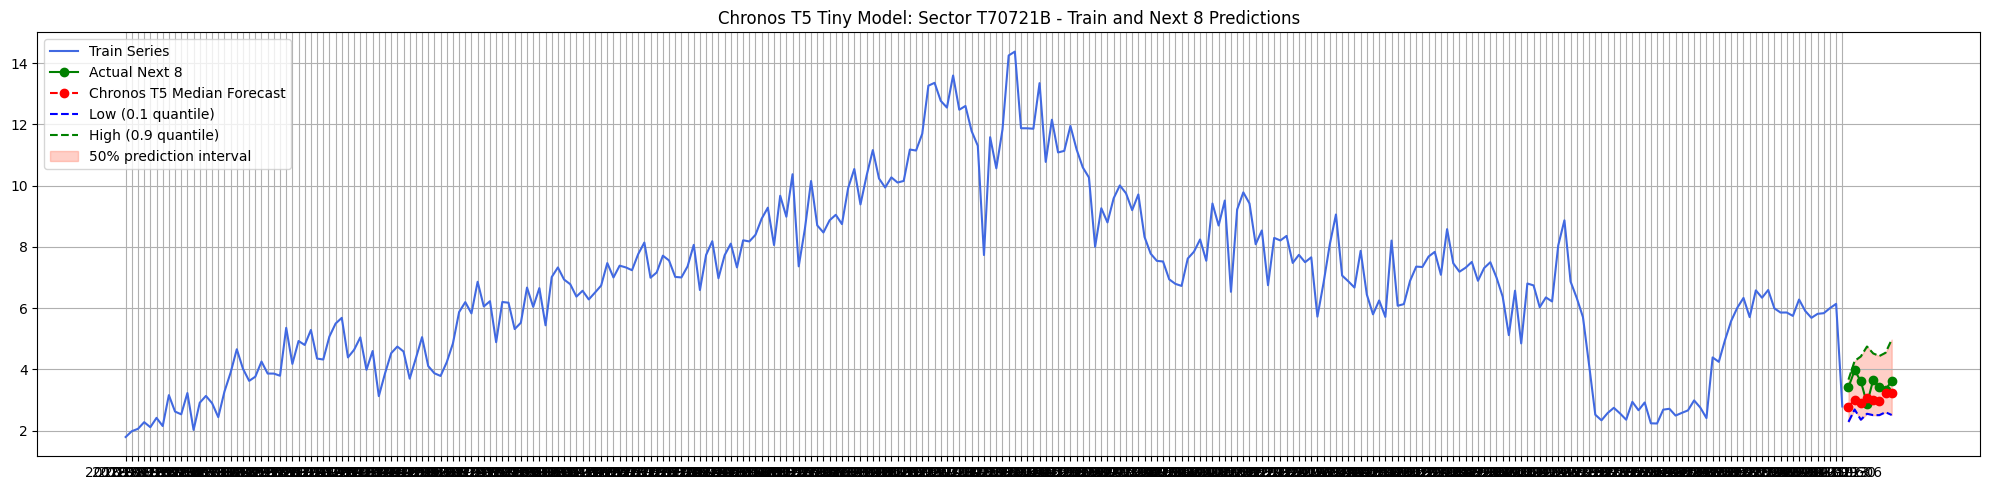

In [12]:
import random

t5_pipeline = ChronosPipeline.from_pretrained(
            "amazon/chronos-t5-tiny",
            device_map="cpu",
            torch_dtype=torch.float32
        )

# Select a random sector
sector_ids = pd.read_csv("/home/infres/vonguyen/rai-6green-miniproj/dataset/train.csv")['item_id'].unique()
random_sector = random.choice(sector_ids)
print(f"Randomly selected sector: {random_sector}")

# Load and sort train/test data for this sector
train_df = pd.read_csv("/home/infres/vonguyen/rai-6green-miniproj/dataset/train.csv")
test_df = pd.read_csv("/home/infres/vonguyen/rai-6green-miniproj/dataset/test.csv")
train_sector = train_df[train_df['item_id'] == random_sector].sort_values('timestamp')
test_sector = test_df[test_df['item_id'] == random_sector].sort_values('timestamp')

# Use all train data as context, predict next 8 points
context = torch.tensor(train_sector['target'].values, dtype=torch.float32)
prediction_length = 8
forecast = t5_pipeline.predict(
    context=context,
    prediction_length=prediction_length,
    num_samples=20,
)
median = np.quantile(forecast[0].numpy(), 0.5, axis=0)
low = np.quantile(forecast[0].numpy(), 0.1, axis=0)
high = np.quantile(forecast[0].numpy(), 0.9, axis=0)

# Get actual next 8 values and timestamps from test
actuals = test_sector['target'].values[:prediction_length]
timestamps_train = train_sector['timestamp'].values
timestamps_pred = test_sector['timestamp'].values[:prediction_length]
forecast_index = range(len(context), len(context) + prediction_length)

# Plot
plt.figure(figsize=(20, 5))
plt.plot(timestamps_train, context.numpy(), color="royalblue", label="Train Series")
plt.plot(forecast_index, actuals, "go-", label="Actual Next 8")
plt.plot(forecast_index, median, "ro--", label="Chronos T5 Median Forecast")
plt.plot(forecast_index, low, "b--", label="Low (0.1 quantile)")
plt.plot(forecast_index, high, "g--", label="High (0.9 quantile)")
plt.fill_between(
    forecast_index,
    low,
    high,
    color="tomato",
    alpha=0.3,
    label="50% prediction interval",
)
plt.legend(loc="upper left")
plt.title(f"Chronos T5 Tiny Model: Sector {random_sector} - Train and Next 8 Predictions")
plt.grid()
plt.tight_layout()
plt.show()

### Chronos T5 Mini

Randomly selected sector: T78270C


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


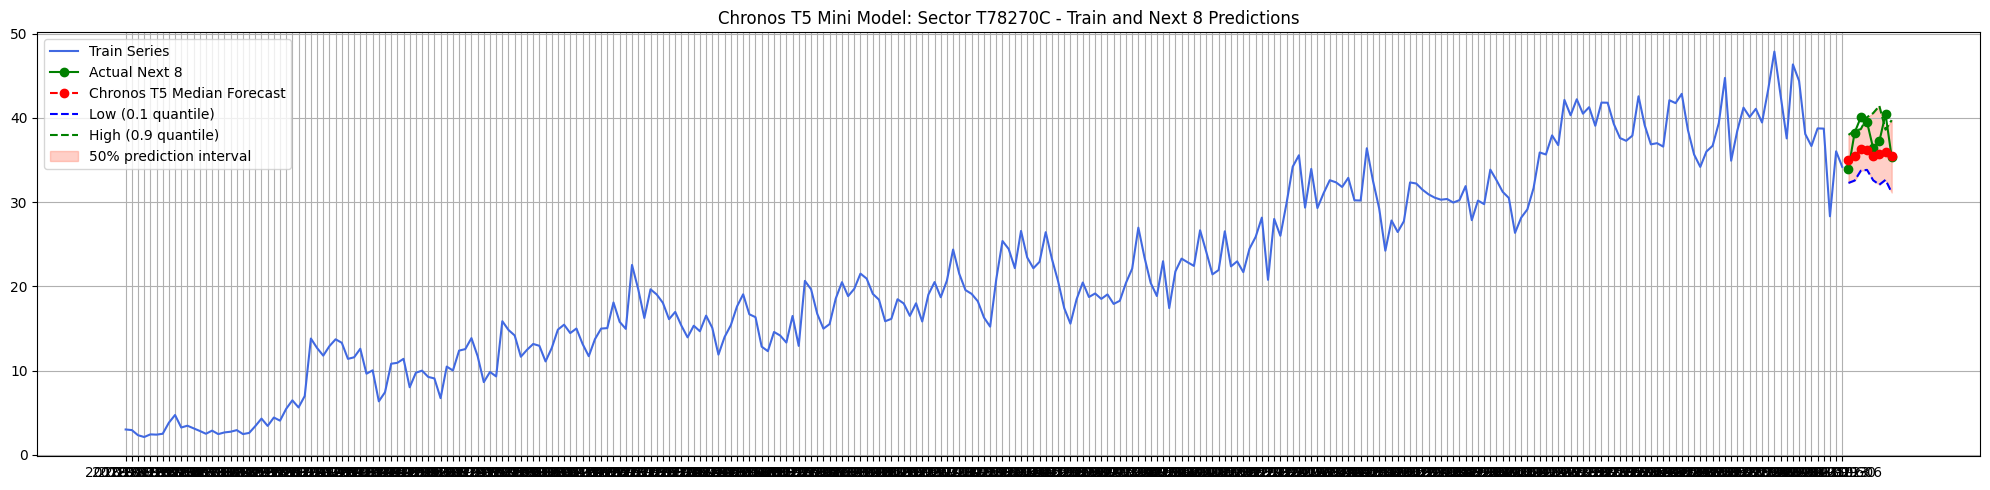

In [19]:
import random

t5_pipeline = ChronosPipeline.from_pretrained(
            "amazon/chronos-t5-mini",
            device_map="cpu",
            torch_dtype=torch.float32
        )

# Select a random sector
sector_ids = pd.read_csv("/home/infres/vonguyen/rai-6green-miniproj/dataset/train.csv")['item_id'].unique()
random_sector = random.choice(sector_ids)
print(f"Randomly selected sector: {random_sector}")

# Load and sort train/test data for this sector
train_df = pd.read_csv("/home/infres/vonguyen/rai-6green-miniproj/dataset/train.csv")
test_df = pd.read_csv("/home/infres/vonguyen/rai-6green-miniproj/dataset/test.csv")
train_sector = train_df[train_df['item_id'] == random_sector].sort_values('timestamp')
test_sector = test_df[test_df['item_id'] == random_sector].sort_values('timestamp')

# Use all train data as context, predict next 8 points
context = torch.tensor(train_sector['target'].values, dtype=torch.float32)
prediction_length = 8
forecast = t5_pipeline.predict(
    context=context,
    prediction_length=prediction_length,
    num_samples=20,
)
median = np.quantile(forecast[0].numpy(), 0.5, axis=0)
low = np.quantile(forecast[0].numpy(), 0.1, axis=0)
high = np.quantile(forecast[0].numpy(), 0.9, axis=0)

# Get actual next 8 values and timestamps from test
actuals = test_sector['target'].values[:prediction_length]
timestamps_train = train_sector['timestamp'].values
timestamps_pred = test_sector['timestamp'].values[:prediction_length]
forecast_index = range(len(context), len(context) + prediction_length)

# Plot
plt.figure(figsize=(20, 5))
plt.plot(timestamps_train, context.numpy(), color="royalblue", label="Train Series")
plt.plot(forecast_index, actuals, "go-", label="Actual Next 8")
plt.plot(forecast_index, median, "ro--", label="Chronos T5 Median Forecast")
plt.plot(forecast_index, low, "b--", label="Low (0.1 quantile)")
plt.plot(forecast_index, high, "g--", label="High (0.9 quantile)")
plt.fill_between(
    forecast_index,
    low,
    high,
    color="tomato",
    alpha=0.3,
    label="50% prediction interval",
)
plt.legend(loc="upper left")
plt.title(f"Chronos T5 Mini Model: Sector {random_sector} - Train and Next 8 Predictions")
plt.grid()
plt.tight_layout()
plt.show()

### Chronos T5 Small

Randomly selected sector: T70730A


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


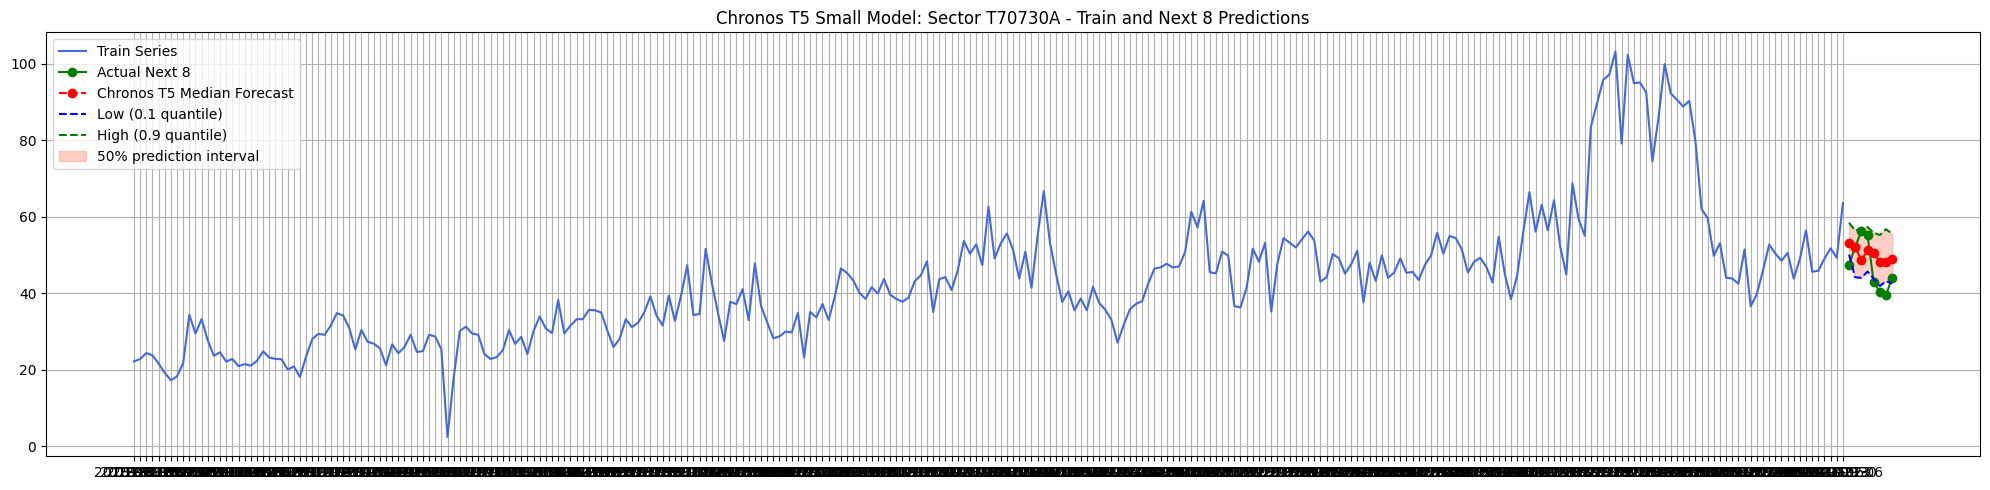

In [32]:
import random

t5_pipeline = ChronosPipeline.from_pretrained(
            "amazon/chronos-t5-small",
            device_map="cpu",
            torch_dtype=torch.float32
        )

# Select a random sector
sector_ids = pd.read_csv("/home/infres/vonguyen/rai-6green-miniproj/dataset/train.csv")['item_id'].unique()
random_sector = random.choice(sector_ids)
print(f"Randomly selected sector: {random_sector}")

# Load and sort train/test data for this sector
train_df = pd.read_csv("/home/infres/vonguyen/rai-6green-miniproj/dataset/train.csv")
test_df = pd.read_csv("/home/infres/vonguyen/rai-6green-miniproj/dataset/test.csv")
train_sector = train_df[train_df['item_id'] == random_sector].sort_values('timestamp')
test_sector = test_df[test_df['item_id'] == random_sector].sort_values('timestamp')

# Use all train data as context, predict next 8 points
context = torch.tensor(train_sector['target'].values, dtype=torch.float32)
prediction_length = 8
forecast = t5_pipeline.predict(
    context=context,
    prediction_length=prediction_length,
    num_samples=20,
)
median = np.quantile(forecast[0].numpy(), 0.5, axis=0)
low = np.quantile(forecast[0].numpy(), 0.1, axis=0)
high = np.quantile(forecast[0].numpy(), 0.9, axis=0)

# Get actual next 8 values and timestamps from test
actuals = test_sector['target'].values[:prediction_length]
timestamps_train = train_sector['timestamp'].values
timestamps_pred = test_sector['timestamp'].values[:prediction_length]
forecast_index = range(len(context), len(context) + prediction_length)

# Plot
plt.figure(figsize=(20, 5))
plt.plot(timestamps_train, context.numpy(), color="royalblue", label="Train Series")
plt.plot(forecast_index, actuals, "go-", label="Actual Next 8")
plt.plot(forecast_index, median, "ro--", label="Chronos T5 Median Forecast")
plt.plot(forecast_index, low, "b--", label="Low (0.1 quantile)")
plt.plot(forecast_index, high, "g--", label="High (0.9 quantile)")
plt.fill_between(
    forecast_index,
    low,
    high,
    color="tomato",
    alpha=0.3,
    label="50% prediction interval",
)
plt.legend(loc="upper left")
plt.title(f"Chronos T5 Small Model: Sector {random_sector} - Train and Next 8 Predictions")
plt.grid()
plt.tight_layout()
plt.show()

### Chronos T5 Base

Randomly selected sector: T70725B


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


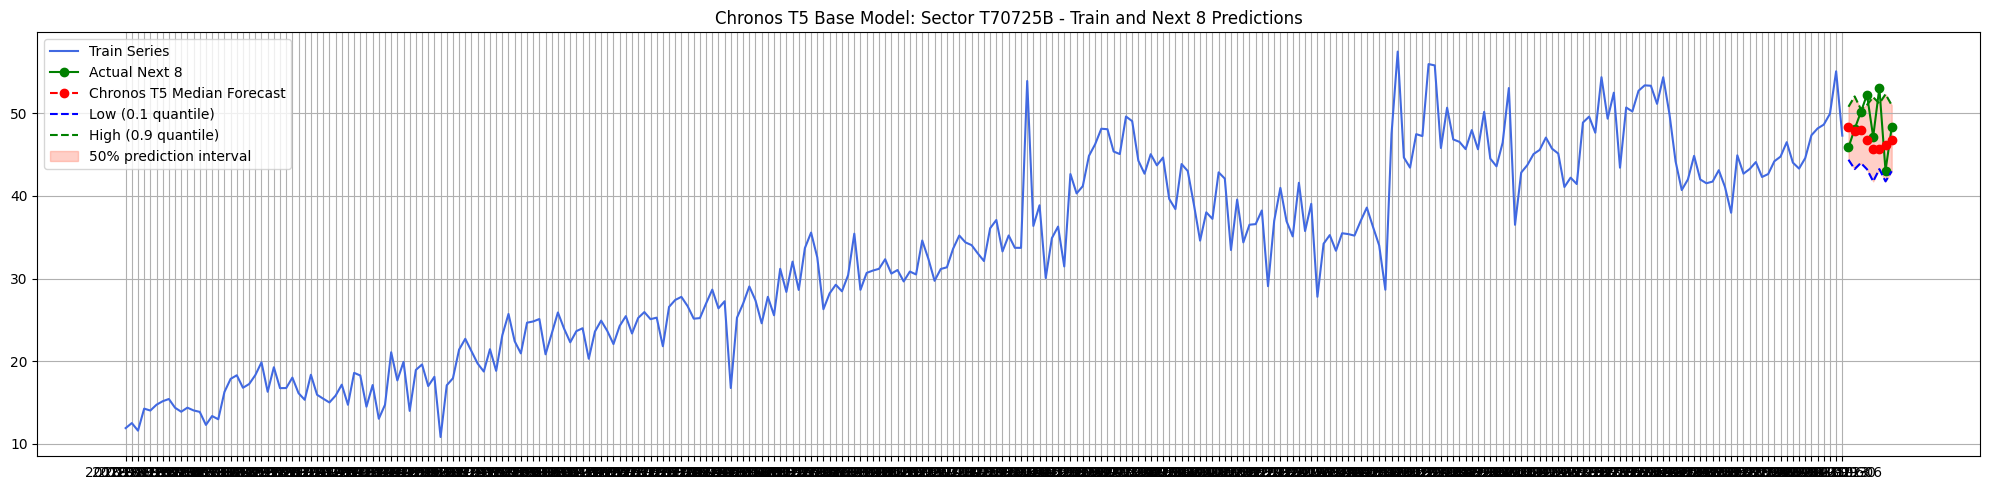

In [40]:
import random

t5_pipeline = ChronosPipeline.from_pretrained(
            "amazon/chronos-t5-base",
            device_map="cpu",
            torch_dtype=torch.float32
        )

# Select a random sector
sector_ids = pd.read_csv("/home/infres/vonguyen/rai-6green-miniproj/dataset/train.csv")['item_id'].unique()
random_sector = random.choice(sector_ids)
print(f"Randomly selected sector: {random_sector}")

# Load and sort train/test data for this sector
train_df = pd.read_csv("/home/infres/vonguyen/rai-6green-miniproj/dataset/train.csv")
test_df = pd.read_csv("/home/infres/vonguyen/rai-6green-miniproj/dataset/test.csv")
train_sector = train_df[train_df['item_id'] == random_sector].sort_values('timestamp')
test_sector = test_df[test_df['item_id'] == random_sector].sort_values('timestamp')

# Use all train data as context, predict next 8 points
context = torch.tensor(train_sector['target'].values, dtype=torch.float32)
prediction_length = 8
forecast = t5_pipeline.predict(
    context=context,
    prediction_length=prediction_length,
    num_samples=20,
)
median = np.quantile(forecast[0].numpy(), 0.5, axis=0)
low = np.quantile(forecast[0].numpy(), 0.1, axis=0)
high = np.quantile(forecast[0].numpy(), 0.9, axis=0)

# Get actual next 8 values and timestamps from test
actuals = test_sector['target'].values[:prediction_length]
timestamps_train = train_sector['timestamp'].values
timestamps_pred = test_sector['timestamp'].values[:prediction_length]
forecast_index = range(len(context), len(context) + prediction_length)

# Plot
plt.figure(figsize=(20, 5))
plt.plot(timestamps_train, context.numpy(), color="royalblue", label="Train Series")
plt.plot(forecast_index, actuals, "go-", label="Actual Next 8")
plt.plot(forecast_index, median, "ro--", label="Chronos T5 Median Forecast")
plt.plot(forecast_index, low, "b--", label="Low (0.1 quantile)")
plt.plot(forecast_index, high, "g--", label="High (0.9 quantile)")
plt.fill_between(
    forecast_index,
    low,
    high,
    color="tomato",
    alpha=0.3,
    label="50% prediction interval",
)
plt.legend(loc="upper left")
plt.title(f"Chronos T5 Base Model: Sector {random_sector} - Train and Next 8 Predictions")
plt.grid()
plt.tight_layout()
plt.show()